#### Imports

In [1]:
import os
import torch
import warnings
import pandas as pd
from transformers import AutoTokenizer
from utils.utils import *
from utils.data import TicketDataset, to_dataloader
from utils.models import ConvNet, EncoderTransformer, BertClassifier
from utils.model_utils import get_class_weights, train_and_evaluate

warnings.simplefilter(action='ignore', category=FutureWarning)
os.environ["TOKENIZERS_PARALLELISM"] = "false"
support_tickets_file = '../data/preprocessed_labeled_complaints.pkl'
save_models = False

/mnt/c/Users/chris/Desktop/Github/Ticket-Classification/ticketenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Loading the Preprocessed Data
***
* For simplicity, I preprocessed the data using my own implementations of the methods used by the author of the dataset and saved the results into an new file so that the data is ready to use.
* This dataset is pulled from Kaggle, where users upload **open-source** datasets for almost any topic.
* The author of the Automatic Ticket Classification Dataset: https://www.kaggle.com/venkatasubramanian

In [2]:
tickets = pd.read_pickle(support_tickets_file)
tickets.sample(5)

,complaint,complaint_lemma,complaint_nouns,topic,label
12043,i received a chase debit card linked to a newl...,I receive a chase debit card link to a newly o...,debit card link checking account company accou...,Bank account services,0
8317,i had a mortgage with chase that i wanted to r...,I have a mortgage with chase that I want to re...,mortgage chase lock rate chase refinance form ...,Mortgages/loans,4
70576,i have made transferred payment to my daughter...,I have make transfer payment to my daughter ac...,payment daughter account bank daughter account...,Bank account services,0
54649,on friday charged over dollars on my debit ...,on friday charge over dollar on my debit ...,charge dollar debit account permission claim p...,Others,2
3194,chase first card allowed to charge to my c...,chase first card allow to charge to my cr...,chase credit card month stay authorization dis...,Theft / Dispute reporting,3


In [3]:
print('Number of tickets:', len(tickets))

Number of tickets: 21072


In [35]:
pd.unique(tickets.topic).tolist()

['Bank account services',
 'Credit card / Prepaid card',
 'Others',
 'Theft / Dispute reporting',
 'Mortgages/loans']

#### Data Frequency Analysis
***
* I create a pipeline to improve the efficiency and modularity of the steps taken to analyse and label the data.
* I then show the top **num_samples** words by frequency.

In [4]:
# I create a pipeline to improve the efficiency and modularity of the steps taken to analyse and label the data.
pipe = vectorizer_pipeline(tickets['complaint_nouns'])

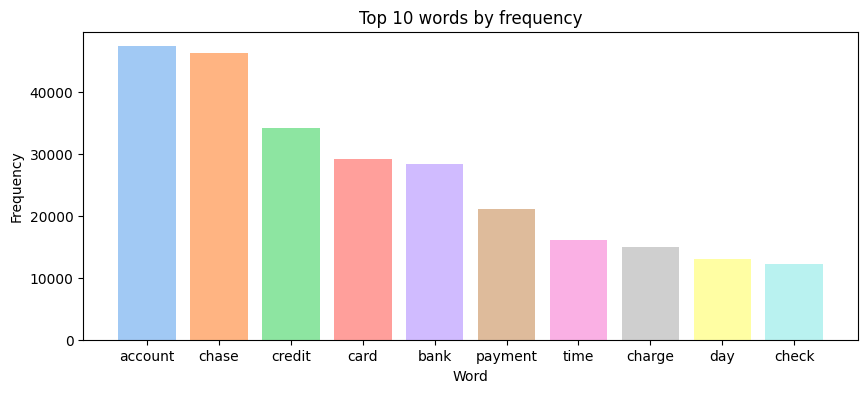

In [5]:
# shows the top nouns across all support tickets.
show_top_words(text=tickets['complaint_nouns'], pipeline=pipe, num_samples=10)

#### Dataset & Dataloader
***
* PyTorch loves dataloaders, it ends up being the easiest way to feed data into the models you develop.
* It is also very efficient since data is fed by a generator, reducing the expensive task of applying the transformations on all the data at once.
* The a dataloader takes a **torch.utils.data.Dataset** object. TicketDataset is the class is used to transform the data in the dataset object into the correct format for the dataloader object. This also works as a generator which increases overall efficiency.

In [6]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
dataset = TicketDataset(tickets, tokenizer)
trainset, testset = to_dataloader(dataset, batch_size=16, split=0.8)

#### Initializing Models & Hyper-Parameters
***
* **EncoderTransformer** is my implementation of a transformer ticket classifier.
* **ConvNet** is my approximation of the neural network described in the paper: *Hyperparameter Black-Box Optimization to Improve the Automatic Classification of Support Tickets*, which I am trying to improve upon with my EncoderTranformer.

##### Hyper-Parameters

In [7]:
epochs = 5
n_embed = 32
block_size = 200
num_filters = 512
embedding_dim = 300
num_ticket_classes = 5
filter_sizes = [5, 4, 3]
vocabulary_size = len(dataset.tokenizer.vocab)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
class_weights = get_class_weights(torch.tensor(tickets['label'].tolist()), num_ticket_classes, mode=2)

##### Models

In [8]:
transformer = EncoderTransformer(
    vocabulary_size, embedding_dim, block_size, num_ticket_classes
).to(device)
cnn = ConvNet(
    vocabulary_size, embedding_dim, num_filters, filter_sizes, num_ticket_classes
).to(device)
bert = BertClassifier(
    num_classes=num_ticket_classes
).to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


#### Train & Evaluate the Models

In [ ]:
transformer, train_acc, test_acc = train_and_evaluate(
    model=transformer, 
    training_data=trainset, 
    validation_data=testset, 
    is_bert=False, 
    class_weights=None, 
    verbose=True, 
    epochs=epochs, 
    device=device
)

In [ ]:
cnn, train_acc, test_acc = train_and_evaluate(
    model=cnn, 
    training_data=trainset, 
    validation_data=testset, 
    is_bert=False, 
    class_weights=class_weights, 
    verbose=True, 
    epochs=epochs, 
    device=device
)

Starting Training
Epoch 0 Complete
- Loss: 1.4724738597869873
Epoch 1 Complete
- Loss: 1.5337328910827637
Epoch 2 Complete
- Loss: 1.0276122093200684
Epoch 3 Complete
- Loss: 1.017243504524231
Epoch 4 Complete
- Loss: 0.8963959813117981
Starting Evaluation
Train Accuracy: 0.871092127899389
Test Accuracy: 0.8241992882562278


In [17]:
bert, train_acc, test_acc = train_and_evaluate(
    model=bert, 
    training_data=trainset, 
    validation_data=testset, 
    is_bert=True, 
    class_weights=None, 
    verbose=True, 
    epochs=epochs, 
    device=device
)

Starting Training
Epoch 0 Complete
- Loss: 1.7022219896316528
Epoch 1 Complete
- Loss: 1.5906702280044556
Epoch 2 Complete
- Loss: 1.5588196516036987
Epoch 3 Complete
- Loss: 1.5041851997375488
Epoch 4 Complete
- Loss: 1.6233906745910645
Starting Evaluation
Train Accuracy: 0.2288070237883372
Test Accuracy: 0.22633451957295372


#### Saving Models
***
If you wish to save the trained models, please uncomment the code below.

In [ ]:
# if save_models:
#     torch.save(transformer.state_dict(), 'transformer.pt')
#     torch.save(cnn.state_dict(), 'cnn.pt')